In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.affinity import rotate
from shapely.geometry import box
from rasterio.plot import show
import rasterio
import math

In [2]:
#import data for patches and sensors
fp_patch = "data/shp/30patches/fl_30Patches.shp"
fp_sensor = "data/shp/Lora_sensors/LORA_SENSORS_30patches.shp"
fp_tmbg = "data/shp/Tempelberg_study_area/Tempelberg_study_area.shp"
fp_raster = "../rasters/high_res_tifs/dop-2022-05-09/dop-2022-05-09.tif"
patches = gpd.read_file(fp_patch)
sensors = gpd.read_file(fp_sensor)
tmpbg_raw = gpd.read_file(fp_tmbg)

tmpbg = tmpbg_raw.to_crs(epsg=25833)

#create bounding box for vis
bounds = tmpbg.total_bounds
minx, miny, maxx, maxy = bounds
bounding_box = gpd.GeoDataFrame({'geometry': [box(minx, miny, maxx, maxy)]})

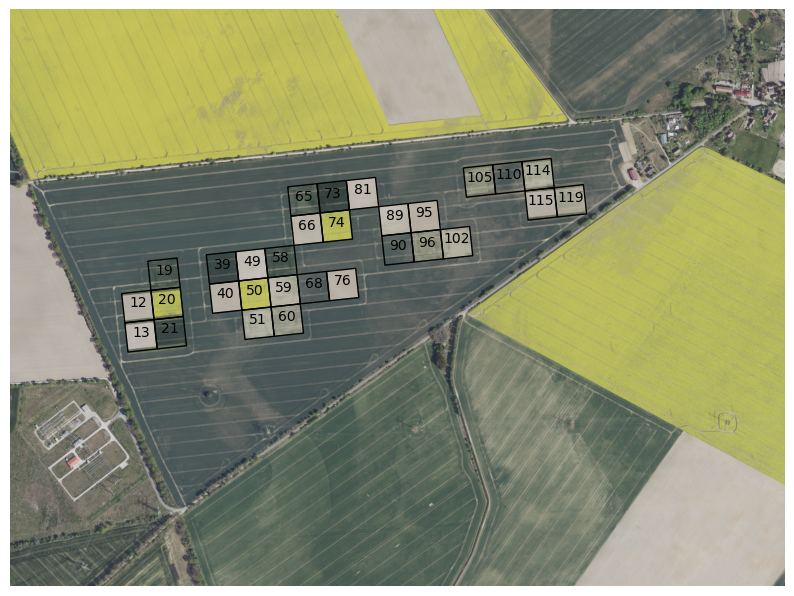

In [9]:
#plot
with rasterio.open(fp_raster) as src:
    # extent = [minx, maxx, miny, maxy]
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    fig, ax = plt.subplots(figsize=(10, 10))

    # tmpbg.plot(ax=ax, facecolor ='none', edgecolor ='k')
    patches.plot(ax=ax, facecolor='none', edgecolor='k')
    # sensors.plot(ax=ax, facecolor='none', edgecolor='k', markersize = 2)
    # bounding_box.boundary.plot(ax=ax, color = 'green', linewidth = 2)

    # ax.set_xlim(minx, maxx)
    # ax.set_ylim(miny, maxy)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    for spine in ax.spines.values():
        spine.set_visible(False)

    patches.apply(lambda x: ax.annotate(text=x['Patch_id'], xy=x.geometry.centroid.coords[0], ha='center', color = 'black'), axis=1)

    show(src)

    fig.savefig("temp/labelled_plots.tiff", dpi=300, bbox_inches='tight', pad_inches=0)

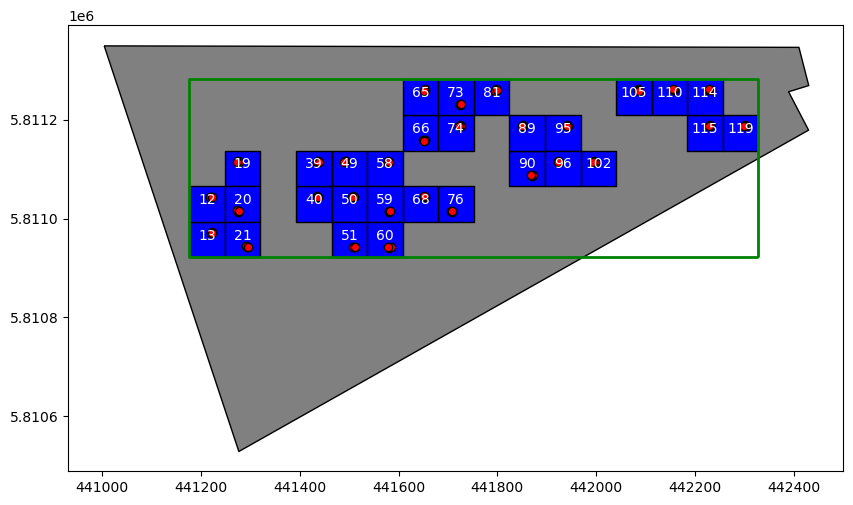

In [176]:
#create rotation point from bottom left patch 13
pivot_point = list(patches.loc[patches['Patch_id']=='13', 'geometry'].iloc[0].exterior.coords)[3]

#calculate theta using patch 13
top_left = list(patches.loc[patches['Patch_id']=='13', 'geometry'].iloc[0].exterior.coords)[0]
top_right = list(patches.loc[patches['Patch_id']=='13', 'geometry'].iloc[0].exterior.coords)[1]
theta = math.degrees(math.atan2(top_right[1] - top_left[1], top_right[0] - top_left[0]))

patches_r = patches.copy()
patches_r['geometry'] = patches_r['geometry'].apply(lambda geom: rotate(geom, angle=-theta, origin=pivot_point))

sensors_r = sensors.copy()
sensors_r['geometry'] = sensors_r['geometry'].apply(lambda geom: rotate(geom, angle=-theta, origin=pivot_point))

tmpgb_r = tmpbg.copy()
tmpgb_r['geometry'] = tmpgb_r['geometry'].apply(lambda geom: rotate(geom, angle=-theta, origin=pivot_point))


bounds2 = patches_r.total_bounds
minx2, miny2, maxx2, maxy2 = bounds2
bb_r = gpd.GeoDataFrame({'geometry': [box(minx2, miny2, maxx2, maxy2)]})

fig, ax = plt.subplots(figsize=(10, 10))
tmpgb_r.plot(ax=ax, color = 'grey', edgecolor = 'k')
patches_r.plot(ax=ax, color='blue', edgecolor='k')
sensors_r.plot(ax=ax, color='red', edgecolor='k')
bb_r.boundary.plot(ax=ax, color = 'green', linewidth = 2)
patches_r.apply(lambda x: ax.annotate(text=x['Patch_id'], xy=x.geometry.centroid.coords[0], ha='center', color = 'white'), axis=1);